<h1 align="center"> FinBERT Training - Evaluation and EDA</h1>


---
> **Bravo Team** <br />
> Department of Management Science and Technology <br />
> Athens University of Economics and Business <br /> 
  

In this notebook we use the FinBERT model from hugging face (link can be found [here](https://huggingface.co/ProsusAI/finbert)) and we train it again to create our final sentiment analysis model for stock news. Here we will present in detail the dataset used, the training process as well as the evaluation of the model in both training and validation dataset. 


## About FinBERT

FinBERT is a pre-trained natural language processing (NLP) model and is used to analyze sentiment of financial text. Analyzing the sentiment of stock news can be a game-changer for trading as it provides the latest insights about a company someone wants to invest in.  It is built by further training the BERT language model in the finance domain, using a large financial corpus and fine-tuning it for financial sentiment classification. 

In our case, we are using the FinBert model to classify the last 17 news' headlines from [marketwatch](https://www.marketwatch.com/) to 3 classes Positive, Negative and Neutral. MarketWatch is a website that provides financial information, business news, analysis, and stock market data. The stock news it hosts are from multiple sources so marketwatch is a great fit for our application.

**Note:** In this notebook, only the training and evaluation of the model is presented and not the deployment. For the deployment please read the README.txt to see how you can access the streamlit dashboard and make use of the true power of our application.

# Libraries' versions and Hardware Specifications

In [2]:
# useful for collaboration reasons
%load_ext watermark 
%watermark 

Last updated: 2022-08-26T17:03:07.497043+03:00

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 8.4.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [3]:
%env TOKENIZERS_PARALLELISM=false
%env WANDB_DISABLED=true
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    roc_curve, 
    auc,
    classification_report
)

from transformers import (
    AutoTokenizer, 
    AutoModel, 
    AdamW, 
    AutoConfig, 
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    AutoModelForSequenceClassification,
    pipeline
)

from datasets import Dataset, load_metric
from typing import List, Tuple
from scipy import interp
from itertools import cycle

import shap
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

env: TOKENIZERS_PARALLELISM=false
env: WANDB_DISABLED=true


In [4]:
%watermark --iversions

pandas    : 1.2.4
numpy     : 1.20.1
torch     : 1.12.1
shap      : 0.41.0
seaborn   : 0.11.1
matplotlib: 3.3.4



## Model loading 

After importing all the necessary libraries, we are ready to import the pretrained model from hugging face and the dataset that we will use for further training. 

In [5]:
class args:
    model = 'ProsusAI/finbert' #setting the name of the model as is in huggingface

The dataset that we used for the training is the Financial PhraseBank from [Malo et al. (2014)](https://www.researchgate.net/publication/251231107_Good_Debt_or_Bad_Debt_Detecting_Semantic_Orientations_in_Economic_Texts). This dataset consists of 4846 financial phrases labeled with the desired classes (positive, negative, neutral). Below, we can see some details about the dataset.

In [6]:
df = pd.read_csv('all-data.csv', 
                 names = ['labels','messages'],
                 encoding='ISO-8859-1')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   labels    4846 non-null   object
 1   messages  4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


In [8]:
df = df[['messages', 'labels']]
df.head()

,messages,labels
0,"According to Gran , the company has no plans t...",neutral
1,Technopolis plans to develop in stages an area...,neutral
2,The international electronic industry company ...,negative
3,With the new production plant the company woul...,positive
4,According to the company 's updated strategy f...,positive


As we notice, there are 604 positive phrases, 2879 negative phrases and 1363 neutral.

In [9]:
labeler = LabelEncoder() # mappings are 1: negative, 2:neutral, 0:positive
df['labels'] = labeler.fit_transform(df['labels'])
df['labels'].value_counts()

1    2879
2    1363
0     604
Name: labels, dtype: int64

In [10]:
labeler.classes_ 

array(['negative', 'neutral', 'positive'], dtype=object)

At this point we are ready to split our dataset into training, test and validation. We choose to use stratification for the splitting to force the distribution of the target variable (classes) among the different splits to be the same. 


# Splitting the data

In [11]:
X, y = df['messages'].values, df['labels'].values

# train, test = 90%, 10%
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.1, stratify=y)

# train : valid = 0.8 : 0.2
xtrain, xvalid, ytrain, yvalid = train_test_split(xtrain, ytrain, test_size=0.2, stratify=ytrain)

The above cell will create the following: </br>
**train**: 72% of the initial dataset </br>
**valid**: 18% of the initial dataset </br>
**test**: 10% of the initial dataset 

In [12]:
X.shape # total number of observations

(4846,)

In [13]:
y.shape

(4846,)

In [14]:
set(y) #classes, we can see that there are indeed 3 classes and that the mapping is complete

{0, 1, 2}

In [15]:
xtrain.shape # number of observations in training dataset ytrain.shape is identical

(3488,)

In [16]:
xtest.shape # number of observations in test dataset

(485,)

In [17]:
xvalid.shape # number of observations in validation dataset

(873,)

In [18]:
# Here we create Datasets by using the now split data
train_dataset_raw = Dataset.from_dict({'text':xtrain, 'labels':ytrain})
valid_dataset_raw = Dataset.from_dict({'text':xvalid, 'labels':yvalid})

In [19]:
# Here, we load the tokenizer of the ProsusAI finbert model.
tokenizer = AutoTokenizer.from_pretrained(args.model)

def tokenize_fn(examples):
    return tokenizer(examples['text'], truncation=True)

In the following cell we use the above function to tokenize the datasets.

In [3]:
train_dataset = train_dataset_raw.map(tokenize_fn, batched=True)
valid_dataset = valid_dataset_raw.map(tokenize_fn, batched=True)
data_collator = DataCollatorWithPadding(tokenizer)

NameError: name 'train_dataset_raw' is not defined

In the next cell we load the ProsusAI finbert model

In [21]:
model = AutoModelForSequenceClassification.from_pretrained(args.model)

The following function will help us find the highest logit probability of each record, and find the accuracy.

In [22]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    preds = np.argmax(logits, axis=-1)
    return {'accuracy': accuracy_score(labels, preds)}

In the following cell we add the training arguments of the finbert model

# Training the model

In [23]:
train_args = TrainingArguments(
    './Finbert Trained/',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=2*16,
    num_train_epochs=5, 
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,    
    do_eval=True,
    do_train=True,
    do_predict=True,
    evaluation_strategy='epoch',
    save_strategy="no",
)

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [24]:
trainer = Trainer(
    model,
    train_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [25]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
***** Running training *****
  Num examples = 3488
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1090


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.377060,0.855670
2,No log,0.355938,0.875143
3,0.574700,0.437882,0.882016
4,0.574700,0.495744,0.880871
5,0.069000,0.528119,0.885452


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 873
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 873
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 873
  Batch size = 32
The following co

TrainOutput(global_step=1090, training_loss=0.29794560266197273, metrics={'train_runtime': 3615.0, 'train_samples_per_second': 4.824, 'train_steps_per_second': 0.302, 'total_flos': 535575584079648.0, 'train_loss': 0.29794560266197273, 'epoch': 5.0})

In [26]:
tokenizer

PreTrainedTokenizerFast(name_or_path='ProsusAI/finbert', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [27]:
#Model classes
model.config.id2label

{0: 'positive', 1: 'negative', 2: 'neutral'}

In [28]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

# Model Evaluation

Now our model is trained and we can proceed to the evaluation. We will evaluate the model in both test and validation datasets.

# Test Dataset

In [29]:
pred_dataset_test_raw = Dataset.from_dict({'text': xtest})

In [30]:
pred_dataset_test = pred_dataset_test_raw.map(tokenize_fn, batched=False) # mapping the test obeservations with our tokenizer

  0%|          | 0/485 [00:00<?, ?ex/s]

In [31]:
output_test = trainer.predict(
    test_dataset=pred_dataset_test
)
test_preds = [np.argmax(x) for x in output_test.predictions] # keeping the max argument which refers to the classified class

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 485
  Batch size = 32


In [32]:
def predictor(list_of_headlines):
    '''
    This function takes as input a list of phrases (or headlines) and uses our model and tokenizer to return the scores
    of each phrase in each class (positive, negative, neutral)
    '''
    clf = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores = True) 
    return clf(list_of_headlines)

# For evaluation in test dataset
test = predictor(list(xtest))

Below, we can see the probabilities of each phrase in each class.

In [33]:
test_headlines = pd.DataFrame(xtest)
test_scores = pd.DataFrame(({d['label']:d['score'] for d in subl} for subl in test))
test_final = pd.concat([test_headlines, test_scores], axis = 1)
test_final.rename(columns={0: 'Headline',
                   'positive': 'Positive',
                     'negative': 'Negative',
                     'neutral': 'Neutral'},
          inplace=True, errors='raise')
test_final

,Headline,Positive,Negative,Neutral
0,The construction of a large woodworking facili...,0.000373,0.993643,0.005984
1,NWC ANALYSIS :,0.000453,0.998833,0.000714
2,Kemira Coatings is the leading supplier of pai...,0.000629,0.001463,0.997909
3,"Cooper SH , the UK distributor for lift equipm...",0.000822,0.000801,0.998377
4,Net sales of the Vegetable Oil Business rose t...,0.000713,0.000871,0.998416
...,...,...,...,...
480,"( ADP News ) - Oct 29 , 2008 - Finnish lifting...",0.000947,0.000729,0.998325
481,It is the first oil company to join RSPO and c...,0.000297,0.005692,0.994012
482,This solution is an extension to the existing ...,0.001086,0.997904,0.001010
483,The platform would continue to be the developm...,0.000391,0.998893,0.000717


At this point, we can print the classification report for the test dataset. This report contains the precision, recall f1-score, support and accuracy metrics as well as the micro average and the weighted average of metrics as we have multiclass classification. 

As we can see the **accuracy** of our model in the test dataset is 89% which is quite good. 

From the **precision** metric we can see that 89% of Positive labels, 93% of Negative labels and 82% of Neutral labels were correct. The macro average of this metric is 88% while the weighted average is 89%.

From the **recall** metric we can see that the 90% of all true Positive phrases, the 91% of all true Negative and the 85% of all Neutral phrases were found correctly. The macro average of this metric is 89% as well as the weighted average too.

**F1 score** is the harmonic mean between precision and recall. It is used to rate performance. In other words, an F1-score is a mean of performance based on precision and recall. As we can see the f1-score for our classes is 89%, 92% and 83% for Positive, Negative and Neutral classes respectively. The macro average of this metric is 88% while the weighted average is 89%.

**Support** is the number of actual occurrences of each class in our dataset. As we can see, there are 61 Positive phrases, 288 Negative and 136 Neutral.

**Note that the Neutral phrases are the hardest to predict**

In [34]:
target_names = ['Positive', 'Negative', 'Neutral'] # Setting the real names of our classes
print(classification_report(ytest, test_preds, target_names=target_names))

              precision    recall  f1-score   support

    Positive       0.89      0.90      0.89        61
    Negative       0.93      0.91      0.92       288
     Neutral       0.82      0.85      0.83       136

    accuracy                           0.89       485
   macro avg       0.88      0.89      0.88       485
weighted avg       0.89      0.89      0.89       485



In [38]:
#Confusion Matrix
def print_confusion_matrix(y_true,
                           y_pred,
                           class_names: List[str],
                           figsize: Tuple[int, int] = (10, 7),
                           fontsize: int = 14) -> pd.DataFrame:
    """
    Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heat-map.

    For something more extraordinary check this repo:
    https://github.com/wcipriano/pretty-print-confusion-matrix


    :param class_names:  An ordered list of class names
    :param figsize: A 2-long tuple, the first value determining the horizontal size of the outputted
                    figure, the second determining the vertical size. Defaults to (10,7).
    :param fontsize: Font size for axes labels. Defaults to 14.
    :return: The confusion matrix as a dataset
    """
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

    df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

    fig = plt.figure(figsize=figsize)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

    except ValueError:

        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),
                                 rotation=0,
                                 ha='right',
                                 fontsize=fontsize)

    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),
                                 rotation=45,
                                 ha='right',
                                 fontsize=fontsize)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    return df_cm

Below we can see the confusion matrix for the test dataset. The matrix presents the number of classes that predicted true or false in each class.

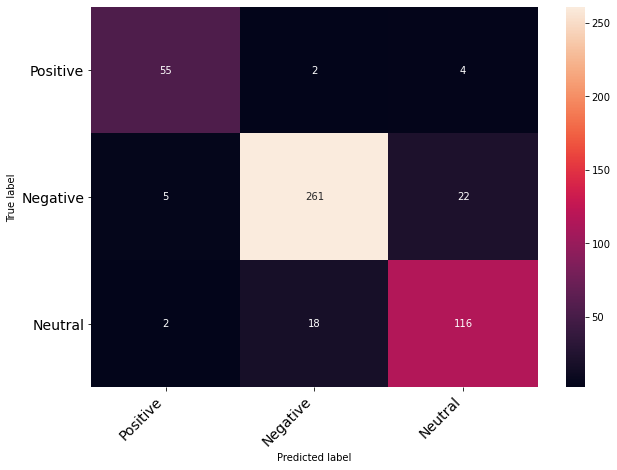

,Positive,Negative,Neutral
Positive,55,2,4
Negative,5,261,22
Neutral,2,18,116


In [39]:
print_confusion_matrix(y_true=ytest,
                           y_pred=test_preds,
                           class_names=['Positive', 'Negative', 'Neutral'])

In [64]:
def plot_multi_class_roc_auc_curves(nb_classes, y_true, y_pred_score, lw: int = 2):
    """
    ROC, AUC for a categorical classifier
    
    ROC curve extends to problems with three or more classes with what is known as the one-vs-all approach.
    For instance, if we have three classes, we will create three ROC curves,

    For each class, we take it as the positive class and group the rest classes jointly as the negative class.

    Class 1 vs classes 2&3
    Class 2 vs classes 1&3
    Class 3 vs classes 1&2

    :param nb_classes:
    :param y_true:
    :param y_pred_score:
    :param lw:
    :return:
    """

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(nb_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_score[:, i])

        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred_score.ravel())

    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(nb_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(nb_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= nb_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(1)
    plt.plot(fpr["micro"],
             tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
             color='deeppink',
             linestyle=':',
             linewidth=4)

    plt.plot(fpr["macro"],
             tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
             color='navy',
             linestyle=':',
             linewidth=4)

    colors = cycle(['aqua',
                    'darkorange',
                    'cornflowerblue'])

    for i, color in zip(range(nb_classes), colors):
        plt.plot(fpr[i],
                 tpr[i],
                 color=color,
                 lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1],
             [0, 1],
             'k--',
             lw=lw)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('Multi-Class Receiver operating characteristic')
    plt.legend(loc="lower right")
    # plt.show()

    # Zoom in view of the upper left corner.
    plt.figure(2)
    plt.xlim(0, 0.2)
    plt.ylim(0.7, 1)

    plt.plot(fpr["micro"],
             tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
             color='deeppink',
             linestyle=':',
             linewidth=4)

    plt.plot(fpr["macro"],
             tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
             color='navy',
             linestyle=':',
             linewidth=4)

    colors = cycle(['aqua',
                    'darkorange',
                    'cornflowerblue'])

    for i, color in zip(range(nb_classes), colors):
        plt.plot(fpr[i],
                 tpr[i],
                 color=color,
                 lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1],
             [0, 1],
             'k--', lw=lw)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class Receiver operating characteristic (zoomed)')
    plt.legend(loc="lower right")
    plt.show()

**ROC curve** (receiver operating characteristic curve) shows the performance of a classification model at all classification thresholds. This curve plots two parameters the True Positive Rate (TPR) and the False Positive Rate (FPR). 

The ROC curve shows the trade-off between sensitivity (or TPR) and specificity (1 – FPR). Classifiers that give curves closer to the top-left corner indicate a better performance. As a baseline, a random classifier is expected to give points lying along the diagonal (FPR = TPR).

The first plot shows the ROC curve for the test dataset while the second one simply zooms to the top-left corner to study better each ROC - curve. In our case as we have a multi-class classification we have 5 curves. Three for the classes (class 0: Positive class, class 1: Negative class and class 2: Neutral class) and two for the averages (macro and weighted average).

As we can see, the Positive class presents the best performance while the Neutral the worst. The overall performance of our model is quite good as all curves are preaty close to the top-left corner with the micro - average and weighted - average ROC curves True Positive Rates beeing close to 90%.

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


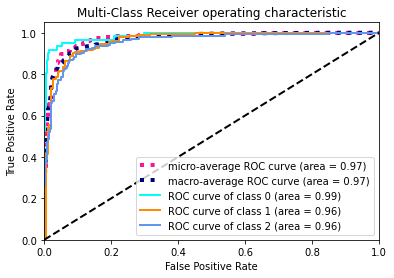

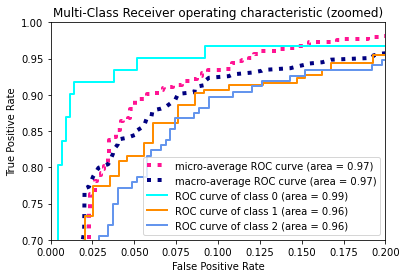

In [65]:
# Binarize the output
y_true_test = label_binarize(ytest, classes=[0, 1, 2])
n_classes = y_true_test.shape[1]
y_pred_test = output_test.predictions

plot_multi_class_roc_auc_curves(nb_classes = n_classes, y_true = y_true_test, y_pred_score = y_pred_test)

# Validation Dataset

In this section, we repeat the same evaluation process but in the validation dataset which wll give us a more realistic performace evaluation of our model.

In [42]:
pred_dataset_valid_raw = Dataset.from_dict({'text': xvalid})

In [43]:
pred_dataset_valid = pred_dataset_valid_raw.map(tokenize_fn, batched=False)

  0%|          | 0/873 [00:00<?, ?ex/s]

In [44]:
output_valid = trainer.predict(
    test_dataset=pred_dataset_valid
)
valid_preds = [np.argmax(x) for x in output_valid.predictions]

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 873
  Batch size = 32


In [45]:
# For evaluation in validation dataset
valid = predictor(list(xvalid))

In [46]:
valid_headlines = pd.DataFrame(xvalid)
valid_scores = pd.DataFrame(({d['label']:d['score'] for d in subl} for subl in valid))
final_valid = pd.concat([valid_headlines, valid_scores], axis = 1)
final_valid.rename(columns={0: 'Headline',
                   'positive': 'Positive',
                     'negative': 'Negative',
                     'neutral': 'Neutral'},
          inplace=True, errors='raise')
final_valid

,Headline,Positive,Negative,Neutral
0,Net sales surged by 30 % to EUR 36 million .,0.001257,0.000634,0.998108
1,The sale will result in a capital loss of EUR5...,0.588677,0.410250,0.001073
2,The core of Solidium 's investment strategy is...,0.001090,0.639210,0.359700
3,"Savon koulutuskuntayhtyma , Finland based comp...",0.001981,0.000895,0.997125
4,26 November 2010 - Finnish sports-equipment ma...,0.000930,0.188761,0.810309
...,...,...,...,...
868,"After piloting , the instrument will be furthe...",0.000372,0.998492,0.001136
869,"Operating profit totaled EUR 37,7 mn , up slig...",0.001526,0.000701,0.997773
870,"Profit for the period was EUR 5.9 mn , up from...",0.000857,0.000890,0.998254
871,Finnish construction group Lemminkainen Oyj HE...,0.002894,0.000491,0.996615


As we can see the **accuracy** of our model in the validation dataset is 89% identical with the test dataset which makes us believe that overfitting is not present. 

From the **precision** metric we can see that 85% of Positive labels, 94% of Negative labels and 80% of Neutral labels were correct. The macro average of this metric is 87% while the weighted average is 89%.

From the **recall** metric we can see that the 91% of all true Positive phrases, the 87% of all true Negative and the 90% of all Neutral phrases were found correctly. The macro average of this metric is 89% as well as the weighted average too.

The **f1-score** for our classes is 88%, 91% and 85% for Positive, Negative and Neutral classes respectively. The macro average of this metric is 88% while the weighted average is 89%.

In addition, we can see that there are 109 Positive phrases, 519 Negative and 245 Neutral.

In [47]:
print(classification_report(yvalid, valid_preds, target_names=target_names))

              precision    recall  f1-score   support

    Positive       0.85      0.91      0.88       109
    Negative       0.94      0.87      0.91       519
     Neutral       0.80      0.90      0.85       245

    accuracy                           0.89       873
   macro avg       0.87      0.89      0.88       873
weighted avg       0.89      0.89      0.89       873



The confusion matrix for the validation dataset is presented below.

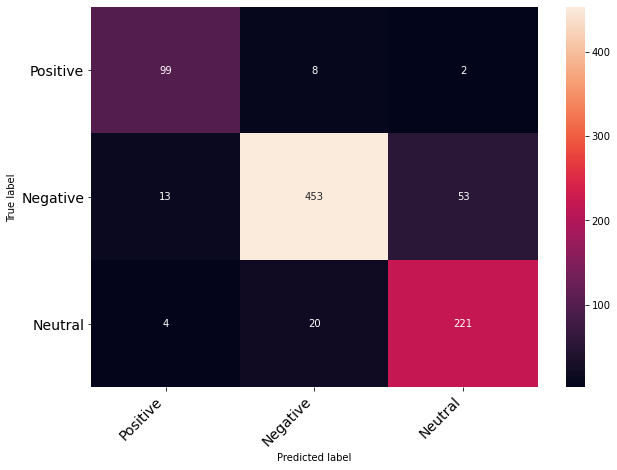

,Positive,Negative,Neutral
Positive,99,8,2
Negative,13,453,53
Neutral,4,20,221


In [51]:
print_confusion_matrix(y_true=yvalid,
                           y_pred=valid_preds,
                           class_names=['Positive', 'Negative', 'Neutral'])

Last but not least as we can see for the ROC curves below, the Positive class presents the best performance while the Negative this time the worst. The overall performance of our model is quite good as all curves are preaty close to the top-left corner with the micro - average and weighted- average ROC curves True Positive Rates beeing more than 90%.

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


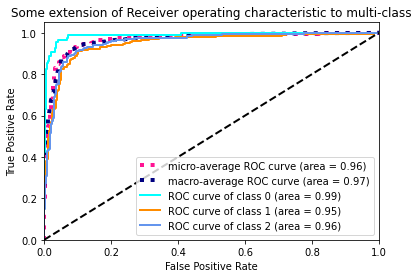

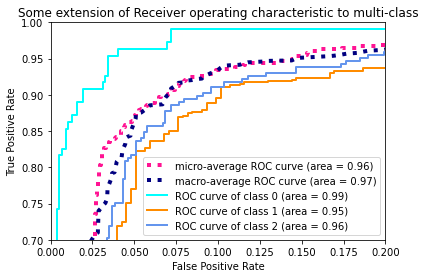

In [52]:
# Binarize the output
y_true_valid = label_binarize(yvalid, classes=[0, 1, 2])
y_pred_valid = output_valid.predictions

plot_multi_class_roc_auc_curves(nb_classes = n_classes, y_true = y_true_valid, y_pred_score = y_pred_valid)

# Understanding how a headline is classified

To further understand which words drive our model to classify a phrase as Positve, Negative or Neutral we can use the SHAP values and create the plot that is presented below. 

SHAP values (SHapley Additive exPlanations) is a method based on cooperative game theory and used to increase transparency and interpretability of machine learning models. A positive SHAP value means positive impact on prediction while a negative SHAP value means negative impact.

The following example, uses our trained model and predicts the class of a given stock news headline. After predicting the class we calculate the SHAP values and create the plot which show which tokens drove our model to clasiffy it as negative.

In [56]:
# A sample of headline to test it
headline_list = [ "Google CEO expreses worries about rising inflation"]

In [57]:
clf = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores = True) 

In [58]:
explainer = shap.Explainer(clf)
shap_values = explainer(headline_list)

shap.plots.text(shap_values[:,:,:]) # shap plots for all headlines